# Sentinel-2 cropland mapping

Following the paper by [Belgiu & Csillik (2018)] (see also [Hao et al. 2018](https://peerj.com/articles/5431/?utm_source=TrendMD&utm_campaign=PeerJ_TrendMD_0&utm_medium=TrendMD))(https://www.sciencedirect.com/science/article/pii/S0034425717304686) we can train a CNN for the segmentation of the croplands. As an input we can use [Sentinel-2 MSI](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) multispectral data, and as an output crop types data classified by experts from the European Land Use and Coverage Area Frame Survey ([LUCAS](https://ec.europa.eu/eurostat/statistics-explained/index.php/LUCAS_-_Land_use_and_land_cover_survey)) and  CropScape – Cropland Data Layer ([CDL](https://nassgeodata.gmu.edu/CropScape/)), respectively.

Datasets in Google Earth Engine:

- [Sentinel-2 MSI: MultiSpectral Instrument, Level-1C](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2)
- [USDA NASS Cropland Data Layers](https://developers.google.com/earth-engine/datasets/catalog/USDA_NASS_CDL)
- [Canada AAFC Annual Crop Inventory](https://developers.google.com/earth-engine/datasets/catalog/AAFC_ACI) 
***

In [193]:
from urllib.request import urlopen
import zipfile
import rasterio
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import display, Image
import os, urllib
import numpy as np
import ee

Initialize the Earth Engine client.

In [2]:
ee.Initialize()

In [79]:
def maskS2clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = int(2**10)
    cirrusBitMask = int(2**11)

    # Both flags set to zero indicates clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(\
           qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000)

In [135]:
def display_image(image, region, mn, mx, bandNames=False, gamma=False, title=False):
    """
    Displays images in notebook
    """
    
    if title:
        print('\n',title)
 
    if not gamma:
        gamma = 1
        
    if bandNames:
        image = image.select(bandNames)
        
    visual = Image(url=image.getThumbUrl({
                'region':region,
                'min':mn,
                'max':mx,
                'gamma':gamma,
                'title':title
                }))
    
    display(visual)

In [313]:
def download_image_tif(image, download_zip, mn, mx, scale, bandNames = False, region = False):
    
    if bandNames:
        image = image.select(bandNames)
        
    Vizparam = {'min': mn, 'max': mx, 'scale': scale, 'crs': 'EPSG:4326'}
    if region:
        Vizparam['region'] = region
    
   
    url = image.getDownloadUrl(Vizparam)     

    print('Downloading image...')
    print("url: ", url)
    data = urlopen(url)
    with open(download_zip, 'wb') as fp:
        while True:
            chunk = data.read(16 * 1024)
            if not chunk: break
            fp.write(chunk)
            
    # extract the zip file transformation data
    z = zipfile.ZipFile(download_zip, 'r')
    target_folder_name = download_zip.split('.zip')[0]
    z.extractall(target_folder_name)
    print('Download complete!')
def load_data(path):
    # Load tiff file data
    with rasterio.open('./data/20150828T110656_20160412T015159_T30SVG.B2.tif') as src:
        data = src.read()
    return data

In [295]:
def download_image_png(image, path_out, mn, mx, scale, bandNames = False, region = False):
    
    if bandNames:
        image = image.select(bandNames)
        
    Vizparam = {'min': mn, 'max': mx, 'scale': scale, 'format': 'png', 'crs': 'EPSG:4326'}
    if region:
        Vizparam['region'] = region
    
    path = image.getThumbURL(Vizparam)
    
    if os.path.exists(path_out):
            os.remove(path_out)
    
    urllib.request.urlretrieve(path, path_out)

In [99]:
# Region of interest
geom = ee.Geometry.Point(-119.5404, 36.2631)
#bbox = (-119.53, 36.25, -119.56, 36.28)
#geom = ee.Geometry.Rectangle(bbox)
# Display region
region = geom.buffer(10000).bounds().getInfo()['coordinates']
# Start and end of time series
startDate = ee.Date('2016-01-01')
stopDate  = ee.Date('2016-12-31')
# Scale in meters
scale = 30

### Sentinel-2 Cloud Free Composite
Cloud masking of Sentinel 2 images using Google Earth Engine Python API. Following this [repo](https://github.com/samsammurphy/cloud-masking-sentinel2) and its corresponding implementation in [javascipt](https://code.earthengine.google.com/b0f7a9069829c883221f4185550e5a0c).
For more information on cloud masking in Sentinel 2 also read this [technical guide](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-1c/cloud-masks).

**Wavebands used for cloud and cloud shadow masking**

|Band 	|Use 		|Wavelength (nm) |Resolution (m)|
|-------|-----------|----------------|--------------|
|B1 	|Aerosols 	|443 	|60|
|B2 	|Blue 		|490 	|10|
|B3 	|Green 		|560 	|10|
|B4 	|Red 		|665 	|10|
|B6 	|Red Edge 2 |740 	|20|
|B8 	|NIR        |835 	|10|
|B8a 	|Red Edge 4 |865 	|20|
|B9 	|Water vapor|940 	|60|
|B10 	|Cirrus 	|1375 	|60|
|B11 	|SWIR 1 	|1610 	|20|
|B12 	|SWIR 2 	|2190 	|20|
|QA60   |ESA Cloud  | n/a   |60|

Load Sentinel-2 TOA reflectance data. 

In [123]:
# Image collection
s2 = ee.ImageCollection('COPERNICUS/S2')

**Single Image**

Select the first image of the collection

In [249]:
dataset = s2.filterBounds(geom)\
    .filterDate(startDate,stopDate)

print("Number of images:", dataset.toList(dataset.size()).size().getInfo())

# Single image
img = ee.Image(dataset.first()).divide(10000)

# Choose the scale
img =  img.reproject(crs='EPSG:4326', scale=scale)

Number of images: 18


In [137]:
# display images
display_image(img, region, 0, 0.3, bandNames=['B4','B3','B2'], gamma=1.5, title='Single image (RGB)')


 Single image (RGB)


**Cloud Free Composite**

Map the cloud masking function over one year of data

In [250]:
dataset = s2.filterBounds(geom)\
    .filterDate(startDate,stopDate)\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))\
    .map(maskS2clouds)

print("Number of images:", dataset.toList(dataset.size()).size().getInfo())

# Composite
composite = dataset.median()

# Choose the scale
composite =  composite.reproject(crs='EPSG:4326', scale=scale)

Number of images: 11


Display composite (RGB)

In [251]:
# display images
display_image(composite, region, 0, 0.3, bandNames=['B4','B3','B2'], gamma=1.5, title='Cloud Free Composite (RGB)')


 Cloud Free Composite (RGB)


Display composite (NIR)

In [252]:
# display images
display_image(composite, region, 0, 0.5, bandNames='B8', title='Cloud Free Composite (NIR)')


 Cloud Free Composite (NIR)


Compute composite's NDVI

In [253]:
#Calculate NDVI
image_ndvi = composite.normalizedDifference(['B8','B4'])

In [254]:
display_image(image_ndvi,region, 0, 0.5, title='Cloud Free Composite (NDVI)')


 Cloud Free Composite (NDVI)


Concatenate images into one multi-band image.

In [255]:
images = ee.Image.cat([composite.select(['B4','B3','B2', 'B8']), image_ndvi]);

Download images tif

In [256]:
download_image_tif(images, 'data.zip', mn=0, mx=0.3, scale=scale, region = region)

url:  https://earthengine.googleapis.com/api/download?docid=d0c800e88a048da32ade4feabeaddd21&token=090c010c00837c0d4a21681bf36707f1
Download complete!


In [257]:
# Load tiff file data
with rasterio.open('./data/eab630454b29d7110a3c895e91599a3a.nd.tif') as src:
    data = src.read()
    profile = src.profile
    transform = src.transform

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


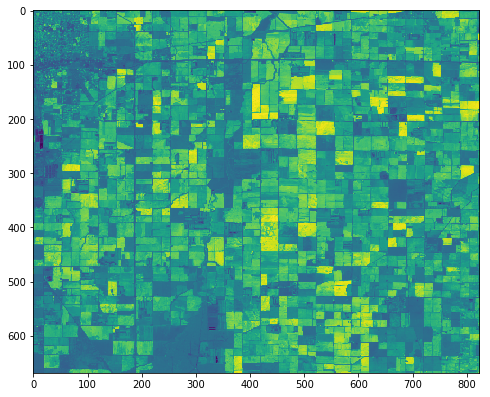

In [264]:
plt.figure(figsize=[8,8])
plt.imshow(data[0,:,:])

In [259]:
data.shape

(1, 669, 824)

Download images png

In [276]:
download_png(images, path_out='./png/sentinel_rgb.png', mn=0, mx=0.3, scale=scale, bandNames = ['B4','B3','B2'], region = region)

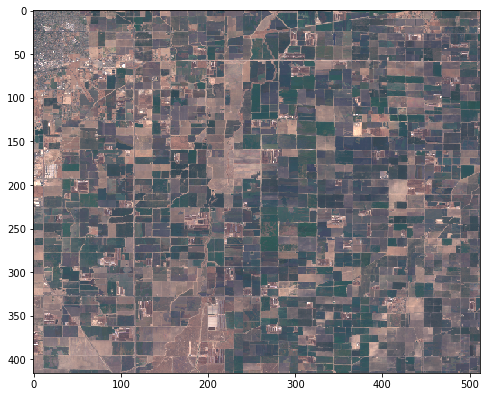

In [277]:
plt.figure(figsize=[8,8])
plt.imshow(plt.imread('./png/sentinel_rgb.png'))

In [278]:
plt.imread('./data/dentinel_rgb.png').shape

(416, 512, 3)

### USDA NASS Cropland Data Layers
**Resolution**
30 meters

**Bands**

|Name 	    |Min|Max |Description 	|
|-----------|---|----|--------------|
|cropland 	|1 	|254 |Main crop-specific land cover classification.|
|cultivated |1 	|2   |Classification layer for identifying cultivated and non-cultivated land cover. Available from 2013 to 2017.|
|confidence |0 	|100 |Per-pixel predicted confidence of the given classification, with 0 being the least confident and 100 the most confident. Available from 2008 to 2017 (Note: Confidence for Florida and Washington D.C. is unavailable for 2010).|

Load USDA NASS Cropland Data Layers.

In [314]:
dataset = ee.ImageCollection('USDA/NASS/CDL')\
    .filterBounds(geom)\
    .filterDate(startDate,stopDate)

print("Number of images:", dataset.toList(dataset.size()).size().getInfo())

# First image
img = ee.Image(dataset.first())

# Choose the scale
img =  img.reproject(crs='EPSG:4326', scale=scale)

Number of images: 1


Display cropland

In [269]:
# display images
display_image(img, region, 1, 254, bandNames='cropland', title='Cropland')


 Cropland


In [270]:
# display images
display_image(img, region, 1, 2, bandNames='cultivated', title='Cultivated')


 Cultivated


In [271]:
# display images
display_image(img, region, 0, 100, bandNames='confidence', title='Confidence')


 Confidence


Download images tif

In [315]:
download_image(img, 'cdl_data.zip', mn=1, mx=254, scale=scale, bandNames='cropland', region = region)

url:  https://earthengine.googleapis.com/api/download?docid=b61922155a0c5ead8cb58806a6171e3f&token=e58c9c7ad4a39b3c3dea876fff23d237
Download complete!


In [316]:
# Load tiff file data
with rasterio.open('./cdl_data/b61922155a0c5ead8cb58806a6171e3f.cropland.tif') as src:
    data = src.read()
    profile = src.profile
    transform = src.transform

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


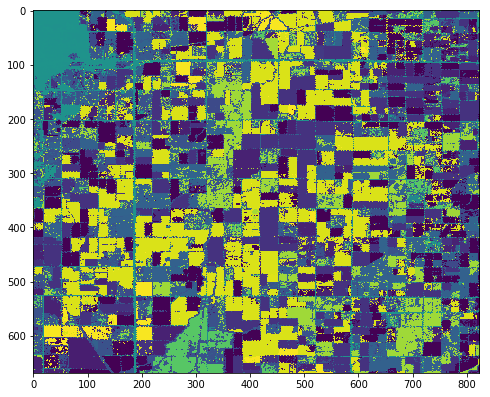

In [317]:
plt.figure(figsize=[8,8])
plt.imshow(data[0,:,:])

In [318]:
data.shape

(1, 669, 824)

Download images png

In [303]:
download_png(img, './png/CDL_cropland.png', 1, 254, scale, bandNames = 'cropland', region = region)

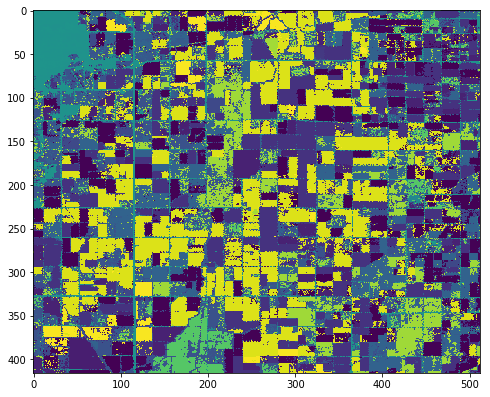

In [304]:
plt.figure(figsize=[8,8])
plt.imshow(plt.imread('./png/CDL_cropland.png'))

In [305]:
plt.imread('./png/CDL_cropland.png').shape

(416, 512)